# Split_by_Seed

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from load import *
from torch.utils.data import Dataset, DataLoader
import glob as glob
import numpy as np

In [2]:
train_28049_2_csv = pd.read_csv('./train_28002.csv')

In [98]:
def train_valid_seed(csv_file = None, transform_train = None, 
                     transform_valid = None ,test_size = .1, random_seed = 42, 
                     shuffle = True, batch_size=1):
    
    df = pd.read_csv(csv_file)
    train_df, valid_df = train_test_split(df, test_size = .1, random_state = random_seed, shuffle = True)
    Dataset_train = SatelliteDataset_From_Df(train_df, transform = transform_train, infer = False)
    Dataset_valid = SatelliteDataset_From_Df(valid_df, transform = transform_valid, infer = False)
    
    train_data_loader = DataLoader(Dataset_train, batch_size=batch_size,shuffle=False)
    valid_data_loader = DataLoader(Dataset_valid, batch_size=batch_size, shuffle=False)
    
    return train_data_loader, valid_data_loader


In [99]:
loader_T, loader_V = train_valid_seed('./train_28002.csv')

In [109]:
iter_T = iter(loader_T)
iter_V = iter(loader_V)

In [73]:
import matplotlib.pyplot as plt

In [115]:
img, msk = next(iter_V)

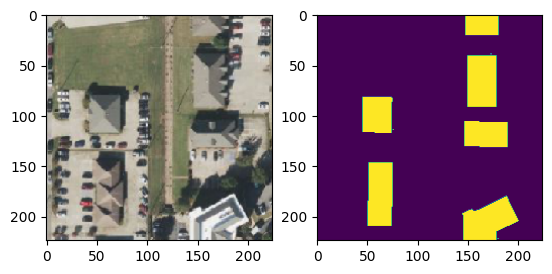

In [116]:

plt.subplot(1,2,2)
plt.imshow(np.array(msk).squeeze(0))
plt.subplot(1,2,1)
plt.imshow(np.array(img).squeeze(0))

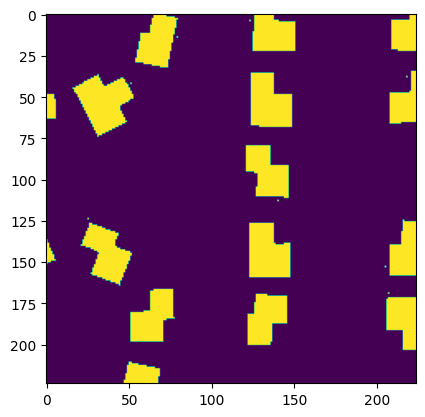

In [114]:
plt.imshow(np.array(msk).squeeze(0))

# Caculate with Dacon Dice

### Import

In [15]:
import os
import re
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
#import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
#from model import UNet_3Plus, DiceLoss, FocalLoss, IoULoss, Dice_score


import segmentation_models_pytorch as smp

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from load_data import *
from run_length_encoding import *
#from load_model import *
from load import *
from loss import *
from dacon_dice import *

from collections import OrderedDict

In [16]:
def get_pos_weight(mask):
    pos_weight = torch.zeros(BATCH_SIZE)
    for i in range(len(mask)):
        num_pos = mask[i][mask[i] == 1.].sum()
        num_neg = 224*224
        pos_weight[i] = num_neg/(num_pos + 1e-5)

    return pos_weight

def get_model(model_str: str):
    if model_str == 'Unet':
        return smp.Unet
    elif model_str == 'FPN':
        return smp.FPN
    elif model_str == 'DeepLabV3Plus':
        return smp.DeepLabV3Plus
    elif model_str == 'UnetPlusPlus':
        return smp.UnetPlusPlus
    elif model_str == 'PAN':
        return smp.PAN
    elif model_str == 'MAnet':
        return smp.MAnet
    elif model_str == 'PSPNet':
        return smp.PSPNet
    
    
def get_optimizer(optimizer_str: str):
    if optimizer_str == 'SGD':
        optimizer = torch.optim.SGD
    elif optimizer_str == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_str == 'AdamW':
        optimizer = torch.optim.AdamW
    else:
        optimizer = None

    return optimizer

def extract_numbers(string):
    numbers = re.findall(r'\d+', string)
    numbers_list = np.array([int(number) for number in numbers])
    #print(numbers_list)
    return np.max(numbers_list)



# 가장 최근에 저장된 모델의 weight를 가져옵니다.
def get_latest_checkpoint(checkpoint_dir):
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, '*.pth'))
    if not checkpoint_files:
        #raise FileNotFoundError(f"No checkpoint files found in {checkpoint_dir}")
        return 0, None

    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    last_epoch = extract_numbers(latest_checkpoint)
    
    return last_epoch, latest_checkpoint


def get_weight(path): 
    '''
    path : model weight가 저장된 디렉토리
    '''
    last_epoch, last_ckpt_path = get_latest_checkpoint(path)
    if last_epoch == 0:
        return False
    else:
        last_ckpt = torch.load(last_ckpt_path)
        return last_epoch, last_ckpt



def get_multi_gpu_weight(path):
    check_point = torch.load(path)
    new_state_dict = OrderedDict()
    for k, v in check_point.items():
        new_state_dict[k[7:]] = v
    return new_state_dict



def get_transform_for_train(version:int=3):
    
    transform_1 = A.Compose(
        [
            A.Normalize(),
            A.OneOf(
                [
                    A.CoarseDropout(50,50,50,15),
                    A.RandomGridShuffle(grid=(2,2))
                ], p = 0.4),
            A.OneOf(
                [
                    # 블러처리
                    A.ColorJitter(),
                    A.ChannelShuffle()             
                ], p = 0.4),
            A.OneOf(
                [
                    #내가 쓰고자하는 모델에서 input size가 어떤게 적합한가
                    A.Resize (224,224),
                    A.RandomCrop(224,224)
                ],p = 1),
            #A.Resize (224,224),
            ToTensorV2()
        ]
    )
    transform_2 = A.Compose(
        [   
            A.Resize(224, 224),
            A.MinMaxNormalize(),
            A.OneOf([
                A.Flip(p=1),
                A.Rotate(p=1),
            ],p = 1),
            ToTensorV2()
        ]
    )
    # for train_20849_2.csv
    transform_3 = A.Compose(
        [   
            A.Normalize(),
            ToTensorV2()
        ]
    )
    
    if version == 1:
        return transform_1
    elif version == 2:
        return transform_2
    elif version == 3:
        return transform_3


def get_transform_for_test():
    transform = A.Compose(
        [   
            A.MinMaxNormalize(),
            ToTensorV2()
        ]
    )
    return transform


def get_dataset(csv_path, transform, infer = False):
    return SatelliteDataset(csv_file = csv_path, transform = transform, infer = infer)


def random_split_train_valid(dataset):
    data_size = len(dataset)
    train_size = int(data_size*TRAIN_SET_RATIO)
    valid_size = data_size - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
    return train_dataset, valid_dataset


def get_data_loader(dataset, is_Train = True):
    return DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = is_Train)

### Model & Gpu Set

In [3]:
BATCH_SIZE = 2
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPUs 0 and 1 to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
ARCHITECTURE = 'UnetPlusPlus'
ENCODER = 'resnet152' #timm-regnety_016
ENCODER_WEIGHT= 'imagenet' #imagenet
N_CLASSES = 1
ACTIVATION = None
OPTIMIZER = 'AdamW'

In [5]:
model = get_model(ARCHITECTURE)
model = model(classes=N_CLASSES,
                encoder_name=ENCODER,
                encoder_weights=ENCODER_WEIGHT,
                activation=ACTIVATION)

In [6]:
ckpt = torch.load('model_save_unet_3/weight_epoch-0041.pth')

In [7]:
model = nn.DataParallel(model)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [8]:
model.to(DEVICE)

DataParallel(
  (module): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu

### Dataset_Setting

In [17]:
BATCH_SIZE = 16

In [18]:
transform_train = get_transform_for_train(version=3)
dataset = get_dataset(csv_path ='/root/jupyter/Dacon/deeplabv3p/train_28049_2.csv', transform = transform_train, infer = False)
dataloader = get_data_loader(dataset, is_Train=False)

In [19]:
num = 0
test_iter = iter(dataloader)

### Pred

In [20]:
total_score = []

In [24]:
for i in range(1): # change range
    imgs, msks = next(test_iter)
    num += 1

In [25]:
with torch.no_grad():
    model.eval()
    images = imgs.float().to(DEVICE)
    outputs = model(images)
    scores = calculate_dice_scores_from_rle(outputs, msks)
    print(scores)
    total_score.append(scores)
    outputs = torch.sigmoid(outputs).cpu().numpy()
    outputs = (outputs > .5).astype(np.uint8) # Threshold = 0.35

0.8705058939617046


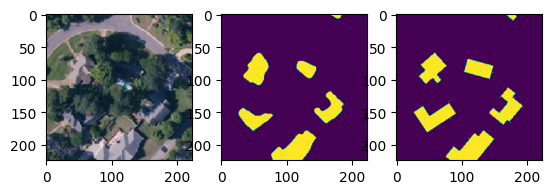

In [26]:
idx = 0
plt.subplot(1,3,1)
plt.imshow(imgs[idx].permute(1,2,0).cpu().numpy())
plt.subplot(1,3,2)
plt.imshow(outputs[idx].squeeze(0)> .5)
plt.subplot(1,3,3)
plt.imshow(msks[idx].cpu().numpy())

In [349]:
scores = calculate_dice_scores_from_rle(outputs, msks)
print(scores)

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [350]:
from dacon_dice import *

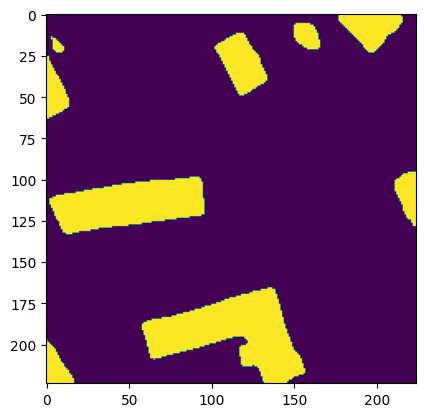

In [351]:
plt.imshow(rle_decode(rle_preds[0] , shape = (224,224)))

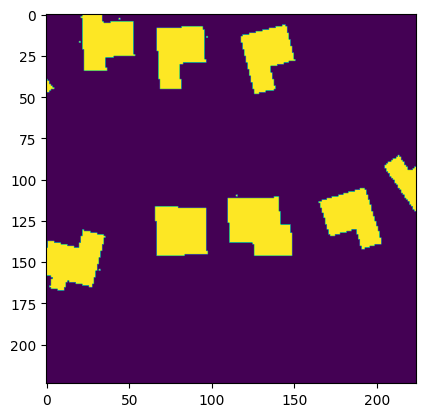

In [48]:
plt.imshow(rle_decode(rle_origins[0] , shape = (224,224)))

### Define function

In [355]:
from joblib import Parallel, delayed
from typing import List, Union


def calculate_dice_scores_from_rle(preds, gts, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    prediction_df -> prediction mask_rle
    ground_truth_df -> ground_truth mask rle
    '''
    
    preds = torch.sigmoid(preds).cpu().numpy()
    preds = (preds > .5).astype(np.uint8)
    
    prediction_rle = []
    ground_truth_rle = []
    for i in range(len(preds)):
        prediction_rle.append(rle_encode(preds[i]))
        ground_truth_rle.append(rle_encode(gts[i]))
    
    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(prediction_rle, ground_truth_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

In [43]:
scores = calculate_dice_scores_from_rle(rle_preds,rle_origins)

In [44]:
scores

0.9717140082063634